Github Link: https://github.com/donxiya/Deep_Learning-Histopathologic-Cancer-Detection


**Introduction:**

In this project, we address the task of detecting metastatic cancer in small image patches derived from larger digital pathology scans, using a modified version of the PatchCamelyon (PCam) benchmark dataset provided on Kaggle. The PCam dataset transforms a clinically significant problem—metastasis detection—into a binary image classification task, making it accessible and computationally efficient while retaining medical relevance. Its well-balanced complexity and tractability allow models to be trained quickly on standard hardware, making it an excellent benchmark for exploring core machine learning concepts such as model performance, regularization, and interpretability.


Citation:

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

In [1]:

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import matplotlib.pyplot as  plt
import seaborn as sns
import os
import glob
from PIL import Image
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import shuffle 

2025-06-13 23:20:21.603869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749856821.874754      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749856821.954395      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#EDA: Data information
pdir = '/kaggle/input/histopathologic-cancer-detection/'
TRAIN_DIR = pdir + 'train/'

df_train = pd.DataFrame({'path': glob.glob(os.path.join(TRAIN_DIR, '*.tif'))}) 
df_train['id'] = df_train['path'].str.extract(r'([^//]+).tif$') 

df_labels = pd.read_csv(pdir + 'train_labels.csv')
df_train = df_train.merge(df_labels, on='id') 
print(df_train.head(5))
print(df_train.info())
print(df_train['path'][0])
print(df_train.shape)
print(df_train.label.value_counts())

                                                path  \
0  /kaggle/input/histopathologic-cancer-detection...   
1  /kaggle/input/histopathologic-cancer-detection...   
2  /kaggle/input/histopathologic-cancer-detection...   
3  /kaggle/input/histopathologic-cancer-detection...   
4  /kaggle/input/histopathologic-cancer-detection...   

                                         id  label  
0  d43c081bafa286f9c1f7e921883f26ceafebc912      1  
1  092d0eedebce504847715ee046b6ad74b57599b4      0  
2  b0d2582c6218a8764323fc940b41312282b99bf4      0  
3  187c99df762f13f99818e5593d4bab4c6577e7e3      1  
4  7c5270c83837de5a5cbb2dca511559dc39d19d53      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    220025 non-null  object
 1   id      220025 non-null  object
 2   label   220025 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


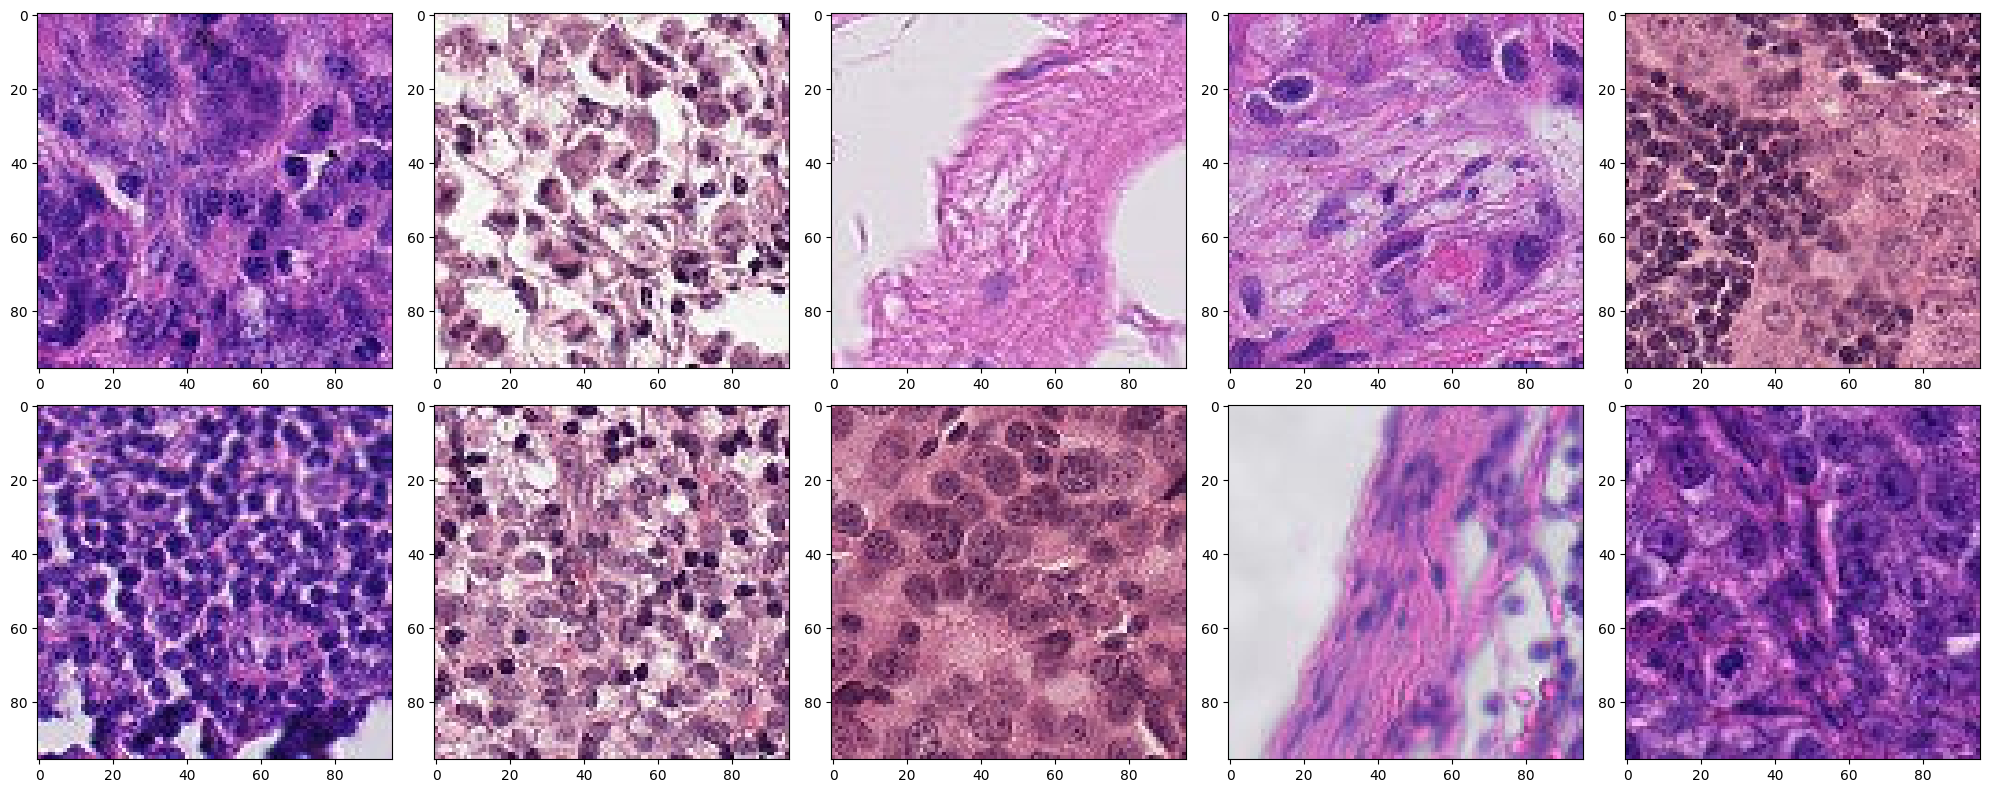

In [4]:
#EDA: display random images
fig = plt.figure(figsize = (20,8))
index = 1
for i in np.random.randint(low = 0, high = df_train.shape[0], size = 10):
    image = mpimg.imread(df_train['path'][i])
    ax = fig.add_subplot(2, 5, index)
    ax.imshow(image, cmap = 'gray')
    index = index + 1
plt.tight_layout()
plt.show()

In [5]:
#EDA: check if any img is pointing to null
#remove any null and NaN
print(df_train.isnull().sum())
df_train = df_train.dropna(subset=['label'])

#check for duplicate
print("Duplicate paths:", df_train.duplicated('path').sum())
print("Duplicate ids:", df_train.duplicated('id').sum())
df_train = df_train.drop_duplicates('id')

path     0
id       0
label    0
dtype: int64
Duplicate paths: 0
Duplicate ids: 0


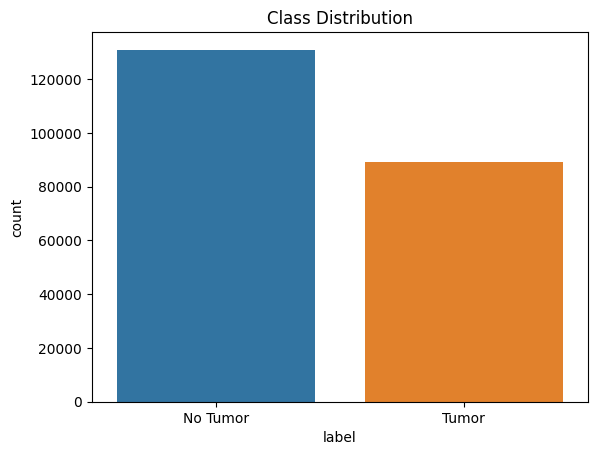

In [6]:
#display class distibution of No Tumor vs Tumor
sns.countplot(data=df_labels, x="label")
plt.title("Class Distribution")
plt.xticks([0, 1], ['No Tumor', 'Tumor'])
plt.show()

In [7]:
#since there is more "No Tumor", we want to balance the ratio
#Balancing the data by undersampling class 0 and random sampling
#sample size is smaller than the full dataset for the sake for processing time
SAMPLE_SIZE = 10000

df_0 = df_train[df_train['label'] == 0].sample(SAMPLE_SIZE, random_state = 0)
df_1 = df_train[df_train['label'] == 1].sample(SAMPLE_SIZE, random_state = 0)

df_train = pd.concat([df_0, df_1], axis = 0).reset_index(drop = True)
df_train = shuffle(df_train)

print(df_train['label'].value_counts())

label
0    10000
1    10000
Name: count, dtype: int64


**PLAN**

**Modeling Strategy:**
Preprocessing
Normalize pixel values to [0, 1] or use ImageNet mean/std if using pretrained models
Apply data augmentation to improve generalization

**Model Choices**
Start with a simple custom CNN to set a baseline
Fine-tune last few layers or use as feature extractor

**Handling Class Imbalance**
Use class_weight in loss function
Optionally, use oversampling or Focal Loss to focus on hard examples

**Training Procedure**
Use stratified train/val split
Monitor accuracy
Apply early stopping and learning rate scheduling

In [8]:
#define variables and file extesions
#train_data = df_labels.copy() 

df_train['filename'] = df_train['id'] + '.tif'
df_train['label'] = df_train['label'].astype(str)

IMG_SIZE = (32, 32)
BATCH_SIZE = 32

In [9]:
#extract center to improve efficiency
def extract_center(img):
    h, w = img.shape[0], img.shape[1]
    center_h, center_w = h // 2, w // 2
    offset = 16  
    center_img = img[center_h-offset:center_h+offset, center_w-offset:center_w+offset, :]
    return center_img

#create data generator for train and val
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=extract_center,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

print(f"Training generator batches: {len(train_generator)}")

validation_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


print(f"Validation generator batches: {len(validation_generator)}")

# calculate steps for training
steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
validation_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Found 16000 validated image filenames belonging to 2 classes.
Training generator batches: 500
Found 4000 validated image filenames belonging to 2 classes.
Validation generator batches: 125
Steps per epoch: 500
Validation steps: 125


**Model Architecture**
classify whether the center 32×32 region of a 96×96 pathology image contains tumor tissue.
Designed for small input size (96×96).
Enough filters to extract texture/patterns common in histology.
Dropout prevents overfitting.

Input: 96×96×3 RGB image

This convolutional neural network is designed for binary image classification and processes 32×32 RGB images. It consists of three convolutional blocks, each followed by ReLU activations and max pooling layers to progressively extract spatial features while reducing dimensionality.

**1st Convolutional Block:**
Two Conv2D layers with 64 filters (3×3, same padding), each followed by ReLU activations, capture low-level features like edges. A MaxPooling2D layer halves the spatial resolution.

**2nd Convolutional Block:**
A Conv2D layer with 128 filters increases feature complexity, followed by a 64-filter layer. ReLU activations follow each convolution, and another max pooling reduces spatial dimensions.

**3rd Convolutional Block:**
This block includes a 256-filter Conv2D layer and another with 64 filters, again followed by ReLU activations and max pooling. This captures higher-level, abstract features.

**Dense Layers:**
The output is flattened and passed through a fully connected layer with 256 units and ReLU activation. A dropout layer with 50% rate is added for regularization. Finally, a dense layer with a single neuron and sigmoid activation outputs a probability for binary classification.


In [10]:
# creat baseline model
def create_baseline_model():
    model = models.Sequential([
        
        # 1st convolutional block
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # 2nd convolutional block
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # 3rd convolutional block
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # flatten and dense layers
        layers.Flatten(),
        layers.Dense(256),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

baseline_model = create_baseline_model()
baseline_model.name = "Baseline"  

print("Baseline CNN Model Summary:")
baseline_model.summary()

Baseline CNN Model Summary:


2025-06-13 23:21:35.075784: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 744,257 (2.84 MB)

 Trainable params: 744,257 (2.84 MB)

 Non-trainable params: 0 (0.00 B)

This CNN extends the baseline model by integrating Batch Normalization after each convolutional and dense layer (prior to activation). The goal is to stabilize and accelerate training by normalizing intermediate outputs, reducing internal covariate shift.

**1st Convolutional Block:**
Two Conv2D layers with 64 filters (3×3, same padding), each followed by BatchNormalization and ReLU activations. This enhances learning stability early in the network. A MaxPooling2D layer reduces spatial dimensions.

**2nd Convolutional Block:**
Two Conv2D layers with 128 filters each, again using BatchNormalization before ReLU activations. Another max pooling layer further downsamples the feature maps.

**3rd Convolutional Block:**
Two Conv2D layers with 256 filters, both normalized and activated. Max pooling completes the block. This captures high-level features with greater robustness due to normalization.

Dense Layers:
The feature maps are flattened, passed to a dense layer with 256 units, followed by BatchNormalization, ReLU activation, and dropout for regularization. The final output layer uses a sigmoid activation for binary classification.

In [11]:
#create batch norm model to compare with baseline
def create_batchnorm_model():
    model = models.Sequential([
        
        # 1st convolutional block with batch normalization
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # 2nd convolutional block with batch normalization
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # 3rd convolutional block with batch normalization
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        # 3rd convolutional block with batch normalization
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # flatten and dense layers
        layers.Flatten(),
        layers.Dense(256),
        layers.BatchNormalization(),  
        layers.Activation('relu'),
        layers.Dropout(0.5),
        
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

batchnorm_model = create_batchnorm_model()
batchnorm_model.name = "BatchNorm"  

print("BatchNorm CNN Model Summary:")
batchnorm_model.summary()

BatchNorm CNN Model Summary:


Model: "BatchNorm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 256)           │           1,0

 Total params: 2,199,105 (8.39 MB)

 Trainable params: 2,196,801 (8.38 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [12]:
#creat callbacks and save to temp file

import tempfile

# Baseline model
baseline_tmp = tempfile.NamedTemporaryFile(suffix=".keras", delete=False)
baseline_path = baseline_tmp.name

# Batch Normalization model
batchnorm_tmp = tempfile.NamedTemporaryFile(suffix=".keras", delete=False)
batchnorm_path = batchnorm_tmp.name

# callbacks 
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    callbacks.ModelCheckpoint(
        filepath=baseline_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# callbacks for the BatchNorm model
batchnorm_callbacks = callbacks_list.copy()

# ModelCheckpoint for BatchNorm
batchnorm_callbacks[-1] = callbacks.ModelCheckpoint(
    filepath=batchnorm_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [13]:

#fit the CNN model
baseline_history = baseline_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    verbose=1
)


Training Baseline CNN Model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5019 - auc: 0.5064 - loss: 0.6937
Epoch 1: val_accuracy improved from -inf to 0.64775, saving model to best_baseline_model.keras

Epoch 1: val_accuracy improved from -inf to 0.64775, saving model to /tmp/tmpsmcg7suq.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 154s 297ms/step - accuracy: 0.5019 - auc: 0.5064 - loss: 0.6937 - val_accuracy: 0.6478 - val_auc: 0.8280 - val_loss: 0.6481 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.6871 - auc: 0.7520 - loss: 0.5866
Epoch 2: val_accuracy improved from 0.64775 to 0.76850, saving model to best_baseline_model.keras

Epoch 2: val_accuracy improved from 0.64775 to 0.76850, saving model to /tmp/tmpsmcg7suq.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 132s 265ms/step - accuracy: 0.6872 - auc: 0.7521 - loss: 0.5865 - val_accuracy: 0.7685 - val_auc: 0.8505 - val_loss: 0.4890 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accu

In [14]:
# train batch normalization model
print("\nTraining BatchNorm CNN Model...")
batchnorm_history = batchnorm_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=batchnorm_callbacks,
    verbose=1
)


Training BatchNorm CNN Model...
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7514 - auc_1: 0.8221 - loss: 0.5505
Epoch 1: val_accuracy did not improve from 0.79875

Epoch 1: val_accuracy improved from -inf to 0.52925, saving model to /tmp/tmpyhmkmja3.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 234s 450ms/step - accuracy: 0.7515 - auc_1: 0.8222 - loss: 0.5504 - val_accuracy: 0.5293 - val_auc_1: 0.7849 - val_loss: 2.0955 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8030 - auc_1: 0.8788 - loss: 0.4417
Epoch 2: val_accuracy did not improve from 0.79875

Epoch 2: val_accuracy improved from 0.52925 to 0.72500, saving model to /tmp/tmpyhmkmja3.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 232s 464ms/step - accuracy: 0.8030 - auc_1: 0.8788 - loss: 0.4417 - val_accuracy: 0.7250 - val_auc_1: 0.8474 - val_loss: 0.5930 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8146 - auc_1: 0.8933 - loss: 0.4127
Ep

In [15]:

# load models & evaluate on validation data
# Load the baseline model
baseline_model = tf.keras.models.load_model(baseline_path)
# Load the batchnorm model
batchnorm_model = tf.keras.models.load_model(batchnorm_path)

baseline_results = baseline_model.evaluate(validation_generator, verbose=1)
batchnorm_results = batchnorm_model.evaluate(validation_generator, verbose=1)

metric_names = baseline_model.metrics_names
metric_names[1] = 'accuracy'

125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.7910 - auc: 0.8747 - loss: 0.4471
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.8438 - auc_1: 0.9190 - loss: 0.3693


In [16]:


#performance visualization

def visualize_model_performance(model, generator, results):
        
    generator.reset()
    prediction_batch_size = BATCH_SIZE * 2
    prediction_steps = (generator.samples + prediction_batch_size - 1) // prediction_batch_size
    
    temp_generator = datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=TRAIN_DIR,
        x_col='filename',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=prediction_batch_size,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )
    y_pred = model.predict(temp_generator, steps=prediction_steps, verbose=1)
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    y_true = generator.classes[:len(y_pred_classes)]
    
    # confusion matrix to view false positive and false negatives
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Non-tumor', 'Tumor'],
        yticklabels=['Non-tumor', 'Tumor']
    )
    plt.title(f'Confusion Matrix - {model.name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # ROC AUC
    false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize=(6, 5))
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model.name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes))
    
    return roc_auc

Found 4000 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step


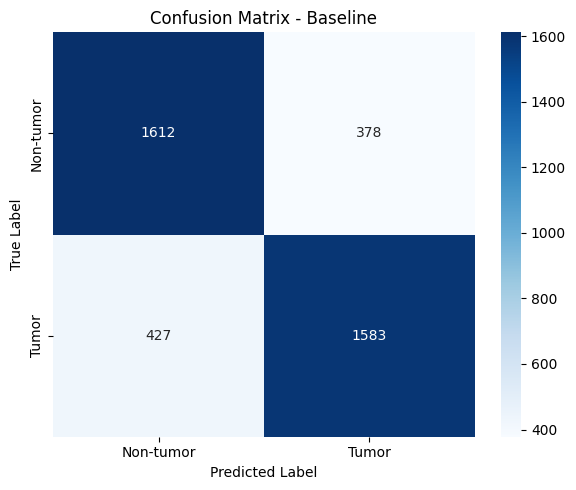

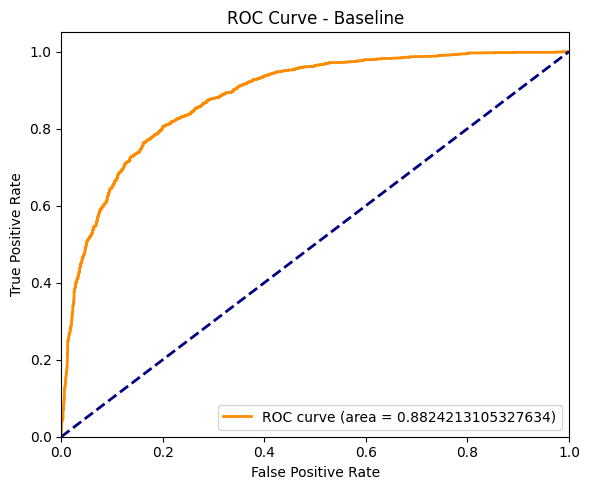


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1990
           1       0.81      0.79      0.80      2010

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000

Found 4000 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step


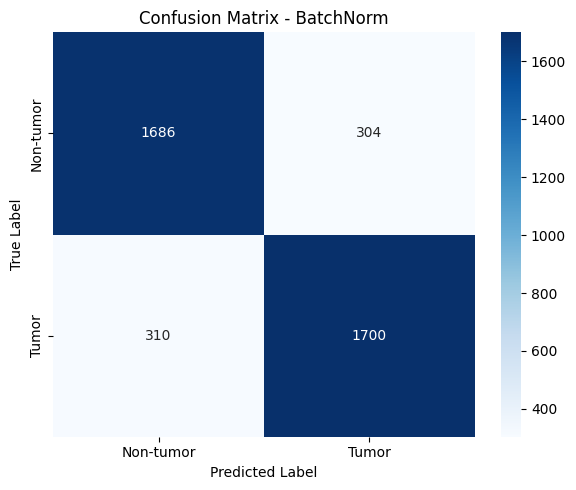

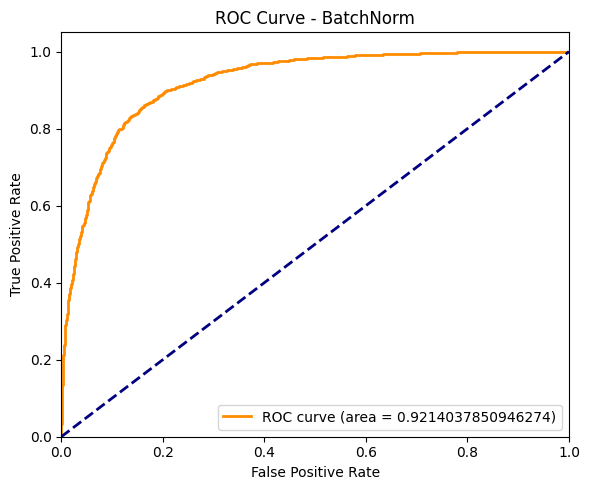


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1990
           1       0.85      0.85      0.85      2010

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



In [17]:
# Get additional metrics (AUC)
baseline_auc = visualize_model_performance(baseline_model, validation_generator, baseline_results)
batchnorm_auc = visualize_model_performance(batchnorm_model, validation_generator, batchnorm_results)

The batch-normalized CNN significantly outperformed the baseline model in all classification metrics:
| Metric    | Baseline | BatchNorm |
| --------- | -------- | --------- |
| Precision | 0.80     | 0.85      |
| Recall    | 0.80     | 0.85      |
| F1-score  | 0.80     | 0.85      |
| Accuracy  | 0.80     | 0.85      |

The improvements are consistent across both classes (0 and 1), suggesting better generalization and more stable training with Batch Normalization (BN).

Higher Learning Rate Tolerance: BN stabilizes gradients, which enables more aggressive learning rates without divergence.

Regularization Effect: BN reduces overfitting, sometimes even removing the need for dropout.


Model Performance Comparison:
           Model  Validation Loss  Validation Accuracy       AUC
0   Baseline CNN         0.433155              0.79875  0.882421
1  BatchNorm CNN         0.364388              0.84650  0.921404


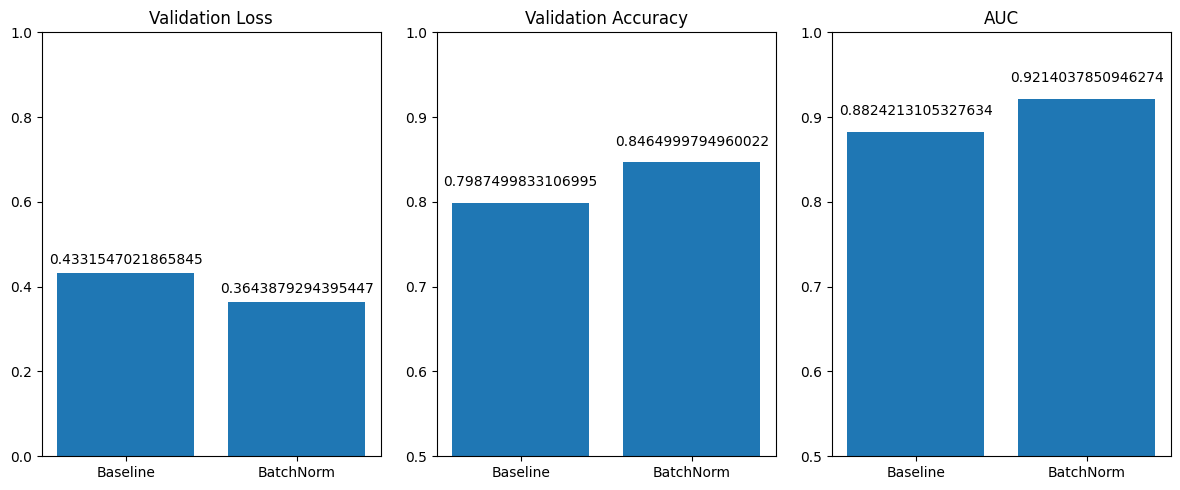

In [18]:
# results table
comparison_df = pd.DataFrame({
    'Model': ['Baseline CNN', 'BatchNorm CNN'],
    'Validation Loss': [baseline_results[0], batchnorm_results[0]],
    'Validation Accuracy': [baseline_results[1], batchnorm_results[1]],
    #'AUC': [baseline_results[2], batchnorm_results[2]],
    'AUC': [baseline_auc, batchnorm_auc]
})

print("\nModel Performance Comparison:")
print(comparison_df)

# compare metrics
metrics = ['Validation Loss', 'Validation Accuracy', 'AUC']
plt.figure(figsize=(12, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(['Baseline', 'BatchNorm'], comparison_df[metric])
    plt.title(metric)
    plt.ylim(0 if metric == 'Validation Loss' else 0.5, 1.0)
    
    for j, v in enumerate(comparison_df[metric]):
        plt.text(j, v + 0.02, f"{v}", ha='center')

plt.tight_layout()
plt.show()


**Validation Loss**

BatchNorm CNN has a significantly lower validation loss (0.3644 vs. 0.4332), which indicates better model calibration and fewer confident but incorrect predictions.

Lower loss also suggests improved stability and smoother gradients during training.

**Validation Accuracy**

Accuracy improved by ~5% with Batch Normalization, from 79.88% to 84.65%.

This is a strong indicator that BN helped the model generalize better and make more correct predictions across the board.

**Area Under the ROC Curve (AUC)**
AUC increased from 0.8824 to 0.9214, meaning the BatchNorm model is more effective at distinguishing between the two classes.

AUC > 0.9 is typically considered excellent for binary classification.


**Summary**
Incorporating Batch Normalization into the CNN architecture led to clear improvements in classification performance. 
The model now learns faster, generalizes better, and predicts more confidently, as seen in higher validation accuracy and AUC, and lower validation loss. 
This validates Batch Normalization as a powerful and effective technique for optimizing CNNs in binary image classification tasks.


**Conclusion**
Adding Batch Normalization significantly improved the model’s performance, increasing validation accuracy from 80% to 85% and AUC from 0.88 to 0.92. This improvement suggests that BN stabilized training, reduced internal covariate shift, and allowed more effective learning. While the baseline CNN performed reasonably well, it was more sensitive to overfitting and slower to converge. The combination of BN and dropout contributed to better generalization. Future improvements could include learning rate scheduling, data augmentation, and experimenting with deeper or transfer learning-based architectures to push performance further.

In [19]:
#submit the code
if baseline_results[1] > batchnorm_results[1]:
    best_model = baseline_model
    print(f"Using Baseline model for submission (accuracy: {baseline_results[1]})")
else:
    best_model = batchnorm_model
    print(f"Using BatchNorm model for submission (accuracy: {batchnorm_results[1]})")

Using BatchNorm model for submission (accuracy: 0.8464999794960022)


In [21]:
# test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

TEST_DIR = '/kaggle/input/histopathologic-cancer-detection/test/'
test_files = os.listdir(TEST_DIR)
test_df = pd.DataFrame({
    'id': [os.path.splitext(file)[0] for file in test_files],
    'filename': test_files
})

In [22]:
submission_batch_size = BATCH_SIZE * 2 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,
    x_col='filename',
    y_col=None,  
    target_size=IMG_SIZE,
    batch_size=submission_batch_size,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [ ]:
# predict
print("\nGenerating predictions for submission...")
predictions = best_model.predict(
    test_generator,
    verbose=1
)
predicted_classes = (predictions > 0.5).astype(int).flatten()


Generating predictions for submission...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


748/898 ━━━━━━━━━━━━━━━━━━━━ 1:26 574ms/step

In [ ]:
# save
submission_df = pd.DataFrame({
    'id': test_df['id'][:len(predicted_classes)],
    'label': predicted_classes
})

submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Submission saved to {submission_path}")
print(f"Sample of submission file:\n{submission_df.head()}")